## Sumário Remissivo
Sumario <a id='sumario'></a>

- [Objetivos](#objetivos)
- [Importando dados](#importando)
- [Preprocessamento de dados](#preprocessamento)
  - [Valores duplicados](#duplicados)
  - [Valores ausentes](#ausentes)
  - [Conversão de tipos de dados](#conversão)
- [Análise exploratória de dados](#exploratória)
  - [Análise da conversão de clientes em diferentes etapas do funil](#conversão-funil)
  - [Análise da distribuição de eventos por usuários entre as amostras](#distribuição-eventos)
  - [Análise se há usuários de ambas as amostras](#usuários-amostras)
  - [Análise do número de eventos distribuídos por dia](#número-eventos)
  - [Conclusões parciais](#conclusões)
- [Teste A/B](#teste)
  - [Conclusões](#conclusões-teste)
- [Teste X verificando a diferença estatística entre as proporções](#x-teste)
  - [Conclusões sobre a etapa da análise exploratória de dados e do resultado do teste A/B](#conclusões-etapa)


## Objetivos:
<a id='objetivos'></a>

idenificar a existencia estatisticamente relevante de mudanças relacionadas à introdução de uma melhoria do sistema 

Resultado esperado: em até 14 dias após o cadastro, usuários mostrarem uma conversão melhor nas visualizações de página do produto (o evento product_page event), ao adicionar itens ao carrinho (product_cart), e compras (purchase).   
  
A cada etapa do funil  
**product_page → product_cart → purchase** ,        
terá ao menos 10% de aumento.  

## Importando dados
<a id='importando'></a>

importando bibliotecas

In [64]:
import pandas as pd
import numpy as np
import math as mth
from scipy import stats as st
import scipy.stats as stats
import datetime as dt
import matplotlib.pyplot as plt
from plotly import graph_objects as go

**legenda das tabelas:**  
*datasets/ab_project_marketing_events_us.csv* = o calendário de eventos de marketing para 2020   
*final_ab_new_users_upd_us.csv* — todos os usuários que se cadastraram na loja online de 7 de dezembro a 21, de 2020  
*final_ab_events_upd_us.csv* — todos os eventos dos novos usuários dentro do período de 7 de dezembro, de 2020 até 1 de janeiro, de 2021  
*final_ab_participants_upd_us.csv* — tabela contendo os participantes do teste

In [65]:
caminho1='/datasets/ab_project_marketing_events_us.csv'
caminho1_2='ab_project_marketing_events_us.csv'

caminho2='/datasets/final_ab_new_users_upd_us.csv'
caminho2_2='final_ab_new_users_upd_us.csv'

caminho3='/datasets/final_ab_events_upd_us.csv'
caminho3_2='final_ab_events_upd_us.csv'

caminho4='/datasets/final_ab_participants_upd_us.csv'
caminho4_2='final_ab_participants_upd_us.csv'



In [66]:
try:
    calendario=pd.read_csv(caminho1)
    usuarios=pd.read_csv(caminho2)
    eventos=pd.read_csv(caminho3)
    teste=pd.read_csv(caminho4)

except:
    calendario=pd.read_csv(caminho1_2)
    usuarios=pd.read_csv(caminho2_2)
    eventos=pd.read_csv(caminho3_2)
    teste=pd.read_csv(caminho4_2)



In [67]:

usuarios
calendario
eventos
teste

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


## Preprocessamento de dados
<a id='preprocessamento'></a>

primeiro renomeamos colunas para nomes mais intuitivos a seguir o significado de cada coluna:

<details>
<summary>
    <b>*Estrutura calendario ↓*</b>
</summary>   
<p>name — do nome dos eventos de marketing</p>    
<p>regions — das regiões onde a campanha será realizada</p>   
<p>start_dt — de data de início da campanha</p>   
<p>finish_dt — da data de término da campanha</p>   
</details>

<details>
<summary>
    <b>*Estrutura usuarios↓*</b>
</summary>
<p>user_id</p>   
<p>first_date — da data de cadastro</p>  
<p>region</p>   
<p>device — do dispositivo usado para o cadastro</p>   
</details>

<details>
<summary>
    <b>*Estrutura eventos:↓*</b>
</summary>
<p>user_id</p>
<p>event_dt — da data e hora do evento</p>  
<p>event_name — do nome da fonte do evento</p>  
<p>details — dos dados adicionais sobre o evento (por exemplo, o total do pedido em USD para eventos purchase)</p>  
</details>

<details>
<summary>
    <b>* Estrutura teste: ↓*</b>
</summary>
<p>user_id</p>
<p>ab_test — nome do teste</p>  
<p>group — o grupo de teste ao qual o usuário pertencia</p>  
</details>


In [68]:
#renomeando calendario
calendarionomes = {'name': 'evento', 'regions': 'regiao', 'start_dt': 'inicio', 'finish_dt': 'fim'}
calendario.rename(columns=calendarionomes, inplace=True)
calendario

,evento,regiao,inicio,fim
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [69]:
#renomeando usuarios
usuariosnomes = {'user_id': 'id_usuario', 'first_date': 'cadastro', 'region': 'regiao', 'device': 'aparelho'}
usuarios.rename(columns=usuariosnomes, inplace=True)
usuarios

,id_usuario,cadastro,regiao,aparelho
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
58698,1DB53B933257165D,2020-12-20,EU,Android
58699,538643EB4527ED03,2020-12-20,EU,Mac
58700,7ADEE837D5D8CBBD,2020-12-20,EU,PC
58701,1C7D23927835213F,2020-12-20,EU,iPhone


In [70]:
#renomeando eventos
eventosnomes = {'user_id': 'id_usuario', 'event_dt': 'data', 'event_name': 'evento', 'details': 'total_dolar'}
eventos.rename(columns=eventosnomes, inplace=True)
eventos

,id_usuario,data,evento,total_dolar
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [71]:
#renomeando teste
testenomes = {'user_id': 'id_usuario', 'ab_test': 'tipo_teste', 'group': 'grupo'}
teste.rename(columns=testenomes, inplace=True)
teste

,id_usuario,grupo,tipo_teste
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


### Valores duplicados
<a id='duplicados'></a>

In [72]:
tabelas=(calendario, usuarios,eventos, teste)
for tabela in tabelas:
    print(tabela.duplicated().sum())

0
0
0
0


### Valores ausentes
<a id='ausentes'></a>

In [73]:
nomes_tabelas = ('calendario', 'usuarios', 'eventos', 'teste')
i=0
for tabela in tabelas:
    print()
    print(nomes_tabelas[i])
    i += 1
    print()
    print(tabela.isnull().sum())


calendario

evento    0
regiao    0
inicio    0
fim       0
dtype: int64

usuarios

id_usuario    0
cadastro      0
regiao        0
aparelho      0
dtype: int64

eventos

id_usuario          0
data                0
evento              0
total_dolar    363447
dtype: int64

teste

id_usuario    0
grupo         0
tipo_teste    0
dtype: int64


In [74]:
eventos['total_dolar'].isnull().sum() / len(eventos)

0.8576697714041641

eventos['total_dolar']    tem muitos valores ausentes 85% a quantidade é enorme, não da para excluir, ou substituir. Entretanto pela natureza da caracteristica, não parece que seja um dado relevante, nesta analise se opta por excluir a coluna inteira na maioria das analises, incluindo só quando não prejudicial.

In [75]:
eventos=eventos.drop('total_dolar',axis=1)
eventos

,id_usuario,data,evento
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase
1,7B6452F081F49504,2020-12-07 09:22:53,purchase
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase
3,96F27A054B191457,2020-12-07 04:02:40,purchase
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase
...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login


### Conversão de tipos de dados
<a id='conversão'></a>

agora verifica-se os tipos de dados. O metodo usado será o de info() aplicado em um loop com as tabelas e seus respectivos nomes. o zip torna isso possível iterando sobre duas variaveis ao mesmo tempo e terminando quando a mais curta terminar

In [76]:
tabelas = (calendario, usuarios, eventos, teste)
nomes_tabelas = ('calendario', 'usuarios', 'eventos', 'teste')

for nome, tabela in zip(nomes_tabelas, tabelas):
    print(tabela.head(2))
    print()
    print(f"Nome da tabela: {nome}")
    print(tabela.info())
    print("\n")




                         evento                    regiao      inicio  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   

          fim  
0  2021-01-03  
1  2020-02-16  

Nome da tabela: calendario
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   evento  14 non-null     object
 1   regiao  14 non-null     object
 2   inicio  14 non-null     object
 3   fim     14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes
None


         id_usuario    cadastro     regiao aparelho
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android

Nome da tabela: usuarios
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
--- 

verifica-se a necessidade de mudar calendario['inicio'], calendario['fim'], usuarios['cadastro']para data e eventos['data'] para datatime 

pode-se aproveitar o mesmo codigo acima, mas agora para verificar se a alteração foi bem sucedida

In [77]:
# Convertendo as colunas 'inicio', 'fim' e 'cadastro' para datetime
calendario['inicio'] = pd.to_datetime(calendario['inicio'])
calendario['fim'] = pd.to_datetime(calendario['fim'])
usuarios['cadastro'] = pd.to_datetime(usuarios['cadastro'])

# Convertendo a coluna 'data' para datetime em eventos
eventos['data'] = pd.to_datetime(eventos['data'])
for nome, tabela in zip(nomes_tabelas, tabelas):
    print(f"Nome da tabela: {nome}")
    print(tabela.info())
    print("\n")
    

Nome da tabela: calendario
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   evento  14 non-null     object        
 1   regiao  14 non-null     object        
 2   inicio  14 non-null     datetime64[ns]
 3   fim     14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes
None


Nome da tabela: usuarios
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id_usuario  58703 non-null  object        
 1   cadastro    58703 non-null  datetime64[ns]
 2   regiao      58703 non-null  object        
 3   aparelho    58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
None


Nome da tabela: eventos
<class 'pandas.core.frame

realizado o preprocessamento de dados, passa-se à analise propriamente dita.

## Análise exploratória de dados:
<a id='exploratória'></a>

In [78]:
print(nomes_tabelas)

('calendario', 'usuarios', 'eventos', 'teste')


### Análise da conversão de clientes em diferentes etapas do funil.
<a id='conversão-funil'></a>

In [79]:
eventos

,id_usuario,data,evento
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase
1,7B6452F081F49504,2020-12-07 09:22:53,purchase
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase
3,96F27A054B191457,2020-12-07 04:02:40,purchase
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase
...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login


In [80]:
funil_eventos=eventos.groupby('evento').count().sort_values(by='data', ascending=False)
funil_eventos

,id_usuario,data
evento,,
login,182465,182465
product_page,120862,120862
purchase,60314,60314
product_cart,60120,60120


In [81]:
eventos['id_usuario'].nunique()

58703

In [82]:
eventos_pivot=eventos.pivot_table(index='id_usuario', columns='evento',values='data', aggfunc='count')
eventos_pivot=eventos_pivot[['login','product_page','product_cart','purchase']]

In [83]:
eventos_pivot

evento,login,product_page,product_cart,purchase
id_usuario,,,,
0001710F4DDB1D1B,2.0,2.0,2.0,NaN
000199F1887AE5E6,4.0,4.0,4.0,4.0
0002499E372175C7,3.0,3.0,NaN,3.0
0002CE61FF2C4011,4.0,4.0,4.0,NaN
000456437D0EFFE1,2.0,2.0,NaN,NaN
...,...,...,...,...
FFF7A7BAF44FE9B4,2.0,NaN,NaN,NaN
FFF8FDBE2FE99C91,4.0,4.0,NaN,4.0
FFF91B6C5431F375,4.0,NaN,4.0,NaN


In [84]:
eventos_pivot=eventos_pivot.sort_values(by=['purchase','product_cart','product_page','login'], ascending=False).reset_index()
eventos_pivot

evento,id_usuario,login,product_page,product_cart,purchase
0,85F47B2DC9F8CCAF,10.0,NaN,NaN,10.0
1,A3917F81482141F2,9.0,9.0,9.0,9.0
2,5F052474F462183E,9.0,NaN,9.0,9.0
3,73E6A2E2A78FDF29,9.0,NaN,9.0,9.0
4,18901783BB890FDC,9.0,9.0,NaN,9.0
...,...,...,...,...,...
58698,FF24FCAFA458249D,1.0,NaN,NaN,NaN
58699,FF3CB212079D965B,1.0,NaN,NaN,NaN
58700,FF8F30C49EDE1FDB,1.0,NaN,NaN,NaN
58701,FF9EF5F26C5CC45C,1.0,NaN,NaN,NaN


percebo que tem algo de estranho, pois se os ids referem-se a usuarios, percebo que muitos usuarios pularam etapas do funil até a compra

In [85]:
eventos_pivot[eventos_pivot['login']<eventos_pivot['purchase']]

evento,id_usuario,login,product_page,product_cart,purchase
35,9770341B414AE0B4,7.0,7.0,NaN,8.0
196,D9E554CF76F449EB,6.0,6.0,NaN,7.0
234,FD88CC5773C0856D,6.0,NaN,NaN,7.0
456,D3B2F392F62F36B8,5.0,5.0,5.0,6.0
457,8F283A6E36B5E729,5.0,NaN,5.0,6.0
...,...,...,...,...,...
16592,D124FDC5154B9ABE,1.0,1.0,NaN,2.0
16593,E201F759D8495D30,1.0,1.0,NaN,2.0
17640,1F46BCE94BD77DF4,1.0,NaN,NaN,2.0
17641,C325FB8F620A9333,1.0,NaN,NaN,2.0


vemos também usuarios que fizeram mais de uma compra com um só login

In [86]:
funil_eventos

,id_usuario,data
evento,,
login,182465,182465
product_page,120862,120862
purchase,60314,60314
product_cart,60120,60120


In [87]:
funil_eventos['data']

evento
login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: data, dtype: int64

In [88]:
funil_eventos=funil_eventos.reset_index()

In [89]:
funil_label=['login','pagina do produto','compra','carro de produtos']

etapas = funil_label
valores = funil_eventos['data']

fig = go.Figure(go.Funnel(y = etapas, x = valores))
#titulo=Funil de conversão dos usuario
fig.update_layout(
    title='Funil de eventos'
)
fig.show()

interessante ver como é a distribuição dos usuarios, não apenas dos eventos, em outras palavras, é bom verificar o numero de clientes que passaram por cada etapa do funil:

para tanto pega-se a tabela pivotada de eventos para contar a quantidade de usuários com valores não nulos para cada evento

In [90]:
valores_por_cliente=eventos_pivot[['login','product_page','product_cart','purchase']].count().sort_values(ascending=False)
valores_por_cliente

evento
login           58696
product_page    38929
purchase        19568
product_cart    19284
dtype: int64

In [91]:
etapas = funil_label
valores = valores_por_cliente

fig = go.Figure(go.Funnel(y = etapas, x = valores))
#titulo=Funil de conversão dos usuario
fig.update_layout(
    title='Funil de conversão dos usuários'
)
fig.show()

o mesmo padrão é encontrado nos dois graficos.

tem-se uma resposta geral, mas e para os grupos teste? tem-se que primeiro juntar as duas tabelas para então filtrar apenas os dados desejados mas primeiro é necessário verificar se há usuarios em ambas as amostras.

### Análise se há usuários de ambas as amostras
<a id='usuários-amostras'></a>

aqui se divide em dois grupos A e B, então filtra-se pelos id que aparecem em ambos A e B, o df resultante são os usuarios que estão em ambas amostras.Após, filtra-se o df inicial pelos ids que NÃO aparecem no filtro dos usuarios de ambas amostras, conforme se ve:

In [92]:
teste['id_usuario'].nunique()

13638

In [93]:
testeA=teste[teste['grupo']=='A']
testeB=teste[teste['grupo']=='B']

In [94]:
testeA=teste[teste['grupo']=='A']
testeB=teste[teste['grupo']=='B']
duplicadosAB=teste[teste['id_usuario'].isin(testeA['id_usuario']) & teste['id_usuario'].isin(testeB['id_usuario'])]


In [95]:
duplicadosAB

,id_usuario,grupo,tipo_teste
15,EAFB9027A27D510C,B,recommender_system_test
26,FC3F3E4DA7C85F88,A,recommender_system_test
27,FE2AF0E94DBD470E,A,recommender_system_test
36,C5AD06762E628169,A,recommender_system_test
53,3B3F68DC5779E517,B,recommender_system_test
...,...,...,...
14354,13FBEB715F4AAE10,A,interface_eu_test
14370,E02247CEF572ACCA,B,interface_eu_test
14395,02313B9E82255F47,B,interface_eu_test
14414,3DEA2F9B3EDA8B91,A,interface_eu_test


tem-se que retirar esses Ids, pois os que participam dos dois grupos podem contaminar a analise. Para tanto, filtra-se com a condição ~ juntamente com isin()

In [96]:
teste_sem_duplicados = teste[~teste['id_usuario'].isin(duplicadosAB['id_usuario'])]
teste_sem_duplicados

,id_usuario,grupo,tipo_teste
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


In [97]:
teste_sem_duplicados['id_usuario'].isin(duplicadosAB['id_usuario']).sum()

0

### Análise da distribuição de eventos por usuários entre as amostras
<a id='distribuição-eventos'></a>

agora juntamos as tabelas e avaliamos a distribuição de eventos entre elas.

In [98]:
eventos['id_usuario'].nunique()

58703

aqui as tabelas eventos usuarios teste_sem_duplicados serão juntadas. O df eventos tem muitos usuarios (58703 usuarios unicos) o df usuarios corresponde a ela, entretanto a tabela teste_sem_duplicados tem um numero bem reduzido de correspondentes.
se usarmos o merge left preservamos todos os valores de testes, se usarmos o padrão, já trabalharemos com a tabela filtrada pelos ids correspondentes a tabela teste_sem_duplicados

In [99]:
dfmerged=eventos.merge(usuarios, on='id_usuario')
dfmerged=dfmerged.merge(teste_sem_duplicados, on='id_usuario')
dfmerged

,id_usuario,data,evento,cadastro,regiao,aparelho,grupo,tipo_teste
0,96F27A054B191457,2020-12-07 04:02:40,purchase,2020-12-07,EU,iPhone,B,interface_eu_test
1,96F27A054B191457,2020-12-08 09:43:14,purchase,2020-12-07,EU,iPhone,B,interface_eu_test
2,96F27A054B191457,2020-12-09 00:44:10,purchase,2020-12-07,EU,iPhone,B,interface_eu_test
3,96F27A054B191457,2020-12-26 00:33:57,purchase,2020-12-07,EU,iPhone,B,interface_eu_test
4,96F27A054B191457,2020-12-07 04:02:41,product_page,2020-12-07,EU,iPhone,B,interface_eu_test
...,...,...,...,...,...,...,...,...
97451,40076B77CFC12421,2020-12-23 03:43:28,login,2020-12-23,EU,iPhone,B,interface_eu_test
97452,40076B77CFC12421,2020-12-24 04:21:53,login,2020-12-23,EU,iPhone,B,interface_eu_test
97453,40076B77CFC12421,2020-12-26 03:50:17,login,2020-12-23,EU,iPhone,B,interface_eu_test
97454,301C602AF78BABAD,2020-12-23 10:39:25,login,2020-12-23,EU,Android,B,interface_eu_test


In [100]:
dfA= dfmerged[dfmerged['grupo']=='A']
dfB=dfmerged[dfmerged['grupo']=='B']
print('numero de eventos de cada amosta A e B:')
print( 'A: ', dfA.shape[0], ' \nB: ', dfB.shape[0], '\nproporção:', round(dfA.shape[0]/dfB.shape[0], 3) )
print('numero de usuarios de cada amosta A e B:')
print('A: ',testeA.shape[0], '\nB: ', testeB.shape[0], '\nproporção:', round(testeA.shape[0]/testeB.shape[0], 3))


numero de eventos de cada amosta A e B:
A:  56014  
B:  41442 
proporção: 1.352
numero de usuarios de cada amosta A e B:
A:  8214 
B:  6311 
proporção: 1.302


aqui se percebe uma diferença significativa entre a quantidade de usuarios, entretanto a proporção de eventosA/eventosB é semelhante a proporção de usuariosA/usuariosB. Em outras palavras a proporção de eventos por usuario é a mesma entre os grupos.

ainda assim, é interessante que se visualize os graficos em funil, é o que se fará usando o mesmo procedimento do grafico de funil anterior.

In [101]:
#dividido por usuario 
dfApivot=dfA.pivot_table(values='data', columns='evento',index='id_usuario',aggfunc='count')
dfBpivot=dfB.pivot_table(values='data', columns='evento',index='id_usuario',aggfunc='count')
dfBpivot

evento,login,product_cart,product_page,purchase
id_usuario,,,,
001064FEAAB631A1,6.0,NaN,6.0,NaN
001E72F50D1C48FA,3.0,NaN,3.0,NaN
0031F1B5E9FBF708,2.0,NaN,NaN,2.0
0036BE15EE4D319D,2.0,NaN,NaN,NaN
003F86A34B575D27,2.0,2.0,NaN,NaN
...,...,...,...,...
FFE40BDB7364E966,3.0,NaN,NaN,3.0
FFE5B14BD55C1C5C,1.0,1.0,NaN,NaN
FFE7FC140521F5F6,4.0,4.0,4.0,4.0


In [102]:
#somando tudo
funilA = dfApivot.notnull().sum().sort_values(ascending=False)
funilA

evento
login           7432
product_page    4937
purchase        2555
product_cart    2357
dtype: int64

In [103]:
funilB = dfBpivot.notnull().sum().sort_values(ascending=False)
funilB

evento
login           5763
product_page    3715
product_cart    1911
purchase        1881
dtype: int64

In [104]:
# Criando um gráfico de funil com Plotly
fig = go.Figure(go.Funnel(
    y=funilA.index,
    x=funilA.values,
    textinfo="value+percent previous",
    marker=dict(color="skyblue"),
))

# título e rótulos aos eixos
fig.update_layout(title="Funil de EventosA",
                  xaxis_title="Número de Usuários",
                  yaxis_title="Eventos")


fig.show()

In [105]:
# Criar um gráfico de funil com Plotly
fig = go.Figure(go.Funnel(
    y=funilB.index,
    x=funilB.values,
    marker=dict(color="skyblue"),
))

# Adicionar título e rótulos aos eixos
fig.update_layout(title="Funil de EventosB",
                  xaxis_title="Número de Usuários",
                  yaxis_title="Eventos")

# Exibir o gráfico
fig.show()

Não há mudança visualmente perceptiva entre os funis das amostras

### Análise do número de eventos distribuídos por dia
<a id='número-eventos'></a>

vamos ver como os valores mudam ao longo do tempo

In [106]:
dfmerged

,id_usuario,data,evento,cadastro,regiao,aparelho,grupo,tipo_teste
0,96F27A054B191457,2020-12-07 04:02:40,purchase,2020-12-07,EU,iPhone,B,interface_eu_test
1,96F27A054B191457,2020-12-08 09:43:14,purchase,2020-12-07,EU,iPhone,B,interface_eu_test
2,96F27A054B191457,2020-12-09 00:44:10,purchase,2020-12-07,EU,iPhone,B,interface_eu_test
3,96F27A054B191457,2020-12-26 00:33:57,purchase,2020-12-07,EU,iPhone,B,interface_eu_test
4,96F27A054B191457,2020-12-07 04:02:41,product_page,2020-12-07,EU,iPhone,B,interface_eu_test
...,...,...,...,...,...,...,...,...
97451,40076B77CFC12421,2020-12-23 03:43:28,login,2020-12-23,EU,iPhone,B,interface_eu_test
97452,40076B77CFC12421,2020-12-24 04:21:53,login,2020-12-23,EU,iPhone,B,interface_eu_test
97453,40076B77CFC12421,2020-12-26 03:50:17,login,2020-12-23,EU,iPhone,B,interface_eu_test
97454,301C602AF78BABAD,2020-12-23 10:39:25,login,2020-12-23,EU,Android,B,interface_eu_test


In [107]:
dfmerged['dia']=dfmerged['data'].dt.date

eventospordia=dfmerged.groupby(['dia','grupo'])['id_usuario'].count().reset_index()



In [108]:
eventospordia

,dia,grupo,id_usuario
0,2020-12-07,A,1273
1,2020-12-07,B,1300
2,2020-12-08,A,1425
3,2020-12-08,B,1343
4,2020-12-09,A,1478
5,2020-12-09,B,1443
6,2020-12-10,A,1565
7,2020-12-10,B,1453
8,2020-12-11,A,1603
9,2020-12-11,B,1404


In [109]:
print(eventospordia['id_usuario'].mean())

2118.608695652174


isso fica emlhor em um gráfico

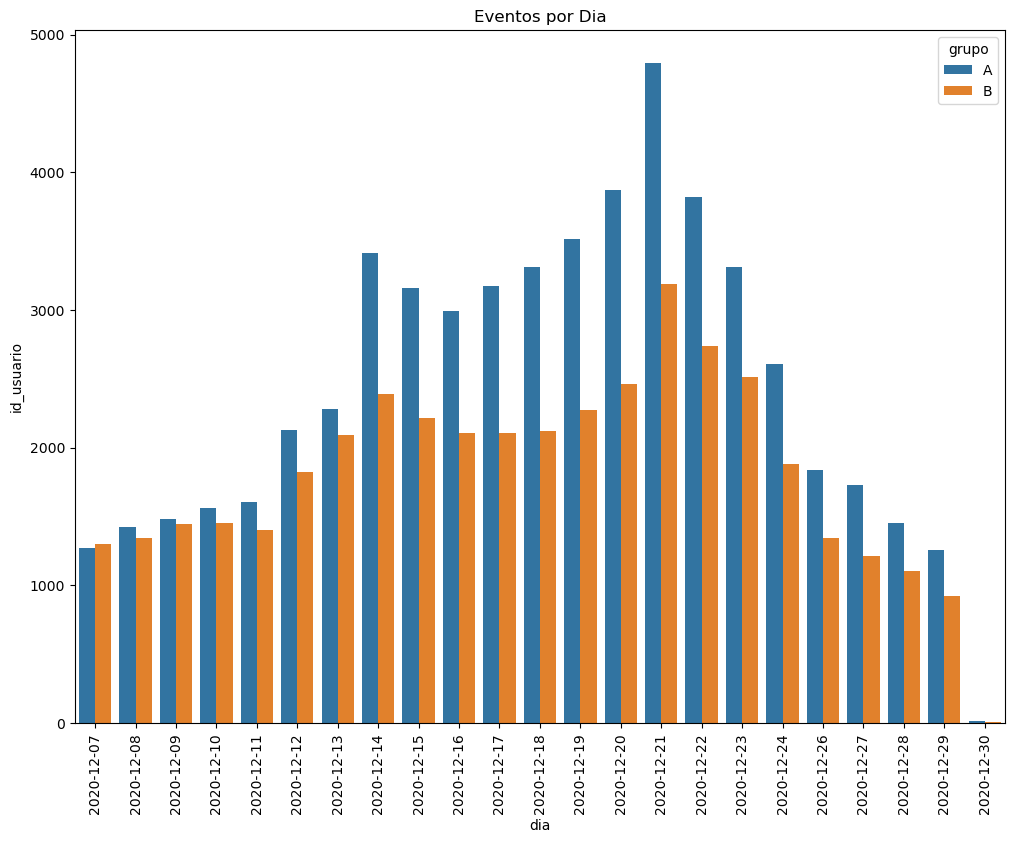

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.title('Eventos por Dia')

# Criar o gráfico de barras com Seaborn
sns.barplot(data=eventospordia, x='dia', y='id_usuario', hue='grupo')

# Rotacionar os rótulos do eixo x para melhorar a legibilidade
plt.xticks(rotation=90)

plt.show()

agora vamos analizar o conjunto inteiro, não só as amostras

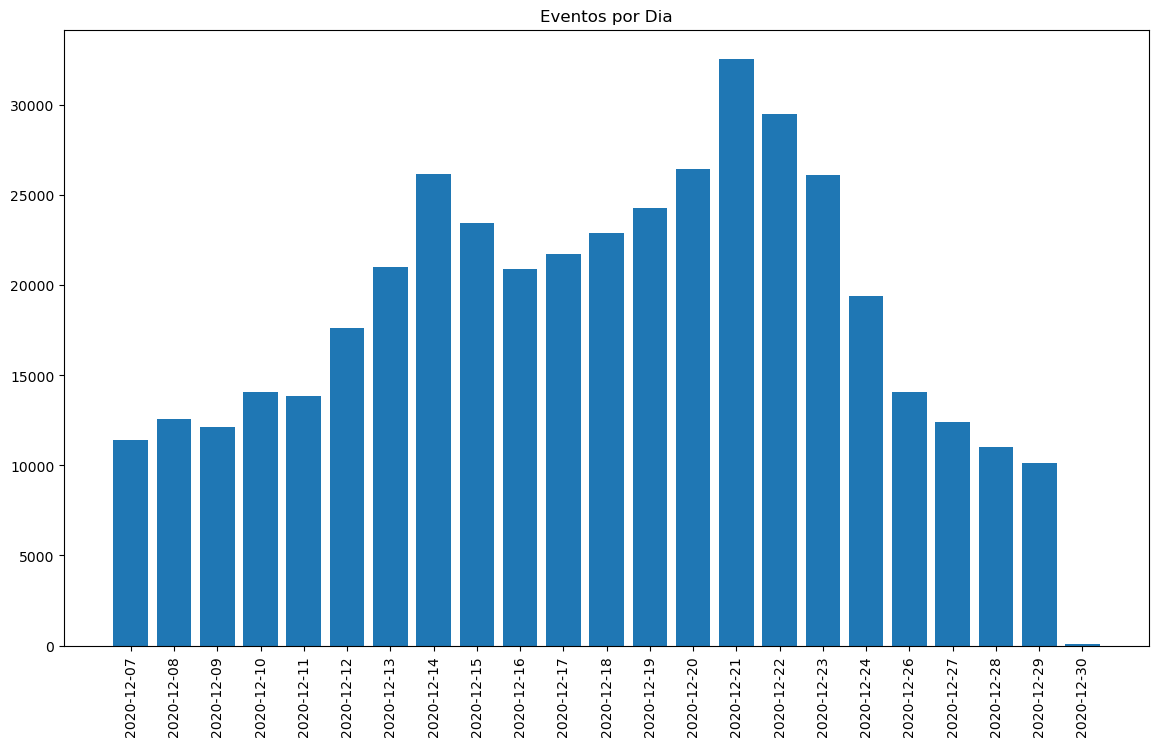

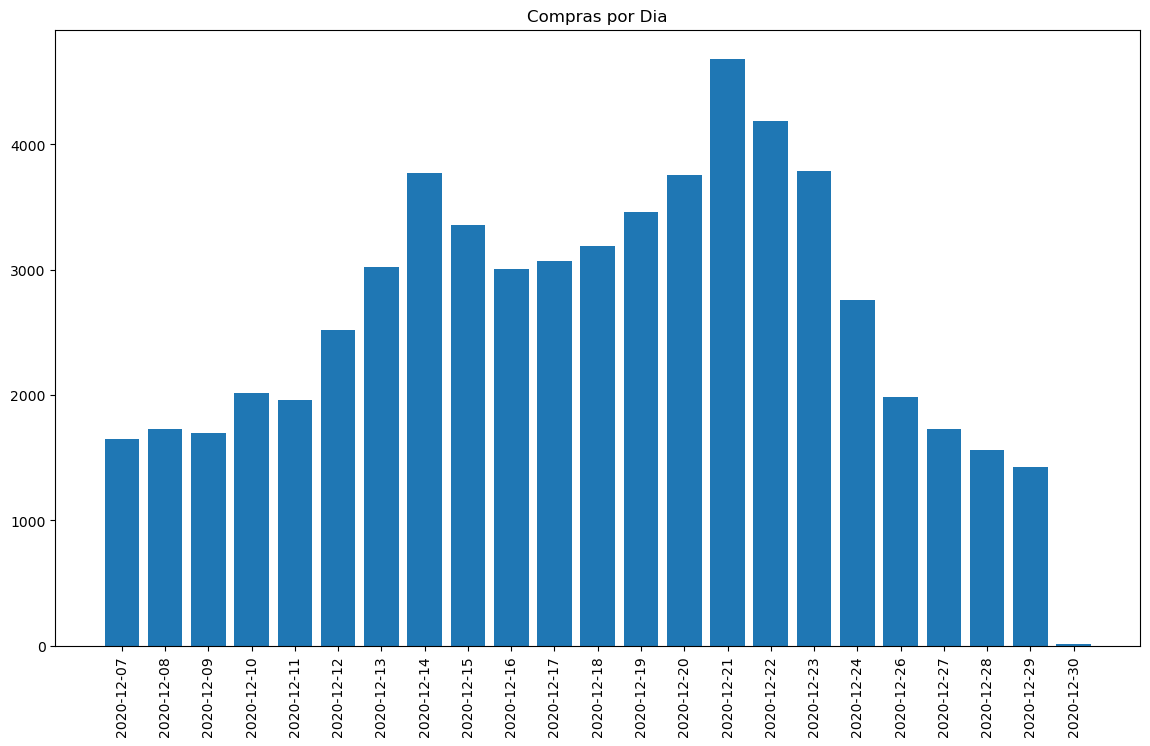

In [111]:

eventos['dia']=eventos['data'].dt.date



eventospordia=eventos.groupby('dia')['id_usuario'].count().reset_index()
plt.figure(figsize=(14, 8))
plt.title('Eventos por Dia')

# Definir os dados
dias = eventospordia['dia'].sort_values(ascending=True)
contagem_eventos = eventospordia['id_usuario']

# Definir a posição dos rótulos no eixo x
posicoes = range(len(dias))

# Criar o gráfico de barras
plt.bar(posicoes, contagem_eventos)

# Definir os rótulos do eixo x
plt.xticks(posicoes, dias, rotation=90)

plt.show()

eventos_compra=eventos[eventos['evento']=='purchase']
compras_por_dia=eventos_compra.groupby('dia')['id_usuario'].count().reset_index()

plt.figure(figsize=(14, 8))
plt.title('Compras por Dia')

# Definir os dados
dias = compras_por_dia['dia'].sort_values(ascending=True)
contagem_eventos = compras_por_dia['id_usuario']

# Definir a posição dos rótulos no eixo x
posicoes = range(len(dias))

# Criar o gráfico de barras
plt.bar(posicoes, contagem_eventos)

# Definir os rótulos do eixo x
plt.xticks(posicoes, dias, rotation=90)

plt.show()

In [112]:
calendario.sort_values(by='inicio')

,evento,regiao,inicio,fim
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


### Conclusões parciais
<a id='conclusões'></a>

os dados dos grupos a e b parecem ser de comportamento muito parecidos, se distinguindo apenas em razão da quantidade de usuários. 

Quanto a analise das vendas no tempo tanto os dados gerais, quanto a filtragem apenas dos eventos de compras seguem o mesmo padrão encontrado nos grupos a e b.

notavelmente tempos dois picos, um no dia 14, outro no dia 21, temos uma curva de crescimento do inicio até o dia 21 e uma curva de declínio do dia 21 até o final. provavelmente já prevendo o tempo de frete até o natal o pico foi dia 21, diminuindo gradativamente até o dia 24. Percebe-se que a loja movimentou nada no dia de natal, talvez até tivesse com o servidor fechado por conta do feriado. Dia 14 e 15 houve um pequeno pico de compras, talvez uma promoção relâmpago em preparação para o natal. após dia 25 os eventos caíram muito.



## Teste A/B:
<a id='teste'></a>

In [113]:
dfApivot

evento,login,product_cart,product_page,purchase
id_usuario,,,,
0002CE61FF2C4011,4.0,4.0,4.0,NaN
0010A1C096941592,4.0,NaN,4.0,4.0
002412F1EB3F6E38,3.0,NaN,3.0,NaN
002540BE89C930FB,3.0,3.0,3.0,NaN
003346BB64227D0C,3.0,NaN,NaN,NaN
...,...,...,...,...
FFC2CFB58A63BE68,2.0,NaN,2.0,NaN
FFC676CB3E0A60B8,2.0,2.0,2.0,NaN
FFDA3BD9A090A179,2.0,2.0,2.0,NaN


para a realização dos testes A B temos que usar as tabelas decompostas dfApivot e dfBpivot, separar apenas as compras de cada usuario, atribuindo 0 aos que não compraram nada e comparar aplicando um teste. nesta analise usaremos o p-test

primeiro substituir os valores ausentes por 0 :

In [114]:
dfApivot['purchase']=dfApivot['purchase'].fillna(0)
dfBpivot['purchase']=dfBpivot['purchase'].fillna(0)

agora pega-se apenas os valores da coluna purchase e depois transforma-se em uma lista

In [115]:
objetoA=dfApivot.reset_index()['purchase']
listaA=objetoA.to_list()

objetoA.describe()

count    7433.000000
mean        1.112337
std         1.774612
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        12.000000
Name: purchase, dtype: float64

In [116]:
objetoB=dfBpivot.reset_index()['purchase']
listaB=objetoB.to_list()

objetoB.describe()

count    5764.000000
mean        1.020819
std         1.676796
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        12.000000
Name: purchase, dtype: float64

aqui percebemos que a diferença media entre os grupos é pequeno, menor que 10% e que os grupos são semelhantes, mas, uma vez que a diferença existe, deve-se calcular a sua relevancia estatistica, em outras palavras, calcular se é provavel de ter sido uma coincidência

In [117]:
len(listaA)/len(listaB)

1.2895558639833449

agora vamos descobrir se é uma distribuição normal:

In [118]:
from statistics import mean
mean(listaA)

1.1123368760930983

In [119]:
mean(listaB)

1.0208188757807077

In [120]:
from scipy.stats import shapiro, levene, ttest_ind 

alpha = .05 # nível de significância

results = st.shapiro(listaA)
p_value = results[1] # o segundo valor no vetor de resultados (com índice 1) - o valor-p

print('p-value: ', p_value)

if (p_value < alpha):
    print("Hipótese nula rejeitada: a distribuição não é normal :(")
else:
    print("Falha ao rejeitar a hipótese nula: a distribuição parece ser normal")

p-value:  0.0
Hipótese nula rejeitada: a distribuição não é normal :(


c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



resposta: Hipótese nula rejeitada: a distribuição não é normal   
    neste caso, usaremos nao o ttest, mas o Mann-Whitney U

In [121]:
from scipy.stats import mannwhitneyu


In [122]:

# Aplique o teste de Mann-Whitney U unilateralmente para saber se B>A 
# para tanto usa-se alternative='greater' e também procurmos pegar as duas respostas do teste: a estatistica e o p_value
statistic, p_value = mannwhitneyu(listaA, listaB, alternative='greater')

# Defina o nível de significância (alpha)
alpha = 0.05

# Imprima o resultado do teste de Mann-Whitney U
print("Estatística do teste de Mann-Whitney U:", statistic)
print("Valor-p:", p_value)

# Verifique se rejeitamos ou não a hipótese nula
if p_value < alpha:
    print("Rejeitamos a hipótese nula. O grupo B teve melhores conversões que o grupo A.")
else:
    print("Não rejeitamos a hipótese nula. Não há evidências de que o grupo B seja 'melhor' que o grupo A.")



Estatística do teste de Mann-Whitney U: 21868661.5
Valor-p: 0.00713815269501532
Rejeitamos a hipótese nula. O grupo B teve melhores conversões que o grupo A.


### Conclusões
<a id='conclusões-teste'></a>

há pouca diferrença entre as conversões, mas ela é estatisticamente relevante para não ser considerada coincidencia

## Teste Z verificando a diferença estatística entre as proporções
<a id='x-teste'></a>

In [123]:
funilB

evento
login           5763
product_page    3715
product_cart    1911
purchase        1881
dtype: int64

In [124]:
totalA=funilA[0]
paginaprodutoA=funilA[1]
comprasA=funilA[2]
product_cartA=funilA[3]


totalB=funilB[0]
paginaprodutoB=funilB[1]
product_cartB=funilB[2]
comprasB=funilB[3]



In [125]:
from statsmodels.stats.proportion import proportions_ztest

lista={
    'login e carro de compra':[[funilA[3], funilB[2]], [funilA[0],funilB[0]]],
    'login e compra':[[funilA[2], funilB[3]], [funilA[0],funilB[0]]],
    'login e pagina do produto':[[funilA[1], funilB[1]], [funilA[0],funilB[0]]],
    'pagina do produto e carro de compra':[[funilA[3], funilB[2]], [funilA[1],funilB[1]]],
    'pagina do produto e compra':[[funilA[2], funilB[3]], [funilA[1],funilB[1]]]
}

for descricao, dados in lista.items():
    # Aplique o teste Z para diferença entre proporções
    statistic, p_value = proportions_ztest(dados[0],dados[1], alternative='larger')

    # Defina o nível de significância (alpha)
    alpha = 0.05
    print(descricao,":")
    # Imprima o resultado do teste Z
    print("Estatística do teste Z:", statistic)
    print("Valor-p:", p_value)

    # Verifique se rejeitamos ou não a hipótese nula

    if p_value < alpha:
        print("Rejeitamos a hipótese nula. \nHá uma diferença estatisticamente significativa entre as conversões:",
            descricao )
    else:
        print("Não rejeitamos a hipótese nula. \nNão há uma diferença estatisticamente significativa entre as conversões:",
            descricao )
 
    print('\n') 

login e carro de compra :
Estatística do teste Z: -1.7606221334098626
Valor-p: 0.960848810051224
Não rejeitamos a hipótese nula. 
Não há uma diferença estatisticamente significativa entre as conversões: login e carro de compra


login e compra :
Estatística do teste Z: 2.097426435376949
Valor-p: 0.017977921495122916
Rejeitamos a hipótese nula. 
Há uma diferença estatisticamente significativa entre as conversões: login e compra


login e pagina do produto :
Estatística do teste Z: 2.357416447020626
Valor-p: 0.009201298044356068
Rejeitamos a hipótese nula. 
Há uma diferença estatisticamente significativa entre as conversões: login e pagina do produto


pagina do produto e carro de compra :
Estatística do teste Z: -3.4060805504869633
Valor-p: 0.9996704863404883
Não rejeitamos a hipótese nula. 
Não há uma diferença estatisticamente significativa entre as conversões: pagina do produto e carro de compra


pagina do produto e compra :
Estatística do teste Z: 1.0312153993615663
Valor-p: 0.1512

### Conclusões sobre a etapa da análise exploratória de dados e do resultado do teste A/B.
<a id='conclusões-etapa'></a>

há diferença estatistica entre os grupos, de fato o grupo B apresentou indices de conversões um pouco melhor que o A ~10% melhor e a probabilidade de existir mesmo diferença nas conversões em compras entre os grupos (e não ser apenas uma coincidencia) foi consideravelmente alta 98% com zteste e 99% com Mann-Whitney U.